# Change Detection using Sentinel-1 SAR data  

In [1]:
algorithm = "deutscher"
version = 0.04

### 1. Query and preprocess Data

> #### Define area and product

In [2]:
product   = "s1g_gamma0_caqueta"
latitude_extents = (    1.487715,   1.540572)
longitude_extents = ( -74.859247 ,-74.81)

> #### Visualize area

In [3]:
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude  = latitude_extents,
            longitude = longitude_extents)  

> #### Load Data

In [4]:
import datacube
dc = datacube.Datacube(app = "notebook: {}, version: {}".format(algorithm, version))

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/psycopg2-2.7.5-py3.5-linux-x86_64.egg/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [5]:
raw_dataset = dc.load(product = product,
                   latitude  = latitude_extents, 
                   longitude = longitude_extents)

In [6]:
raw_dataset

<xarray.Dataset>
Dimensions:    (latitude: 293, longitude: 276, time: 227)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-12T23:20:45.500000 ... 2018-06-28T10:35:06.500000
  * latitude   (latitude) float64 1.541 1.54 1.54 1.54 ... 1.488 1.488 1.488
  * longitude  (longitude) float64 -74.86 -74.86 -74.86 ... -74.81 -74.81 -74.81
Data variables:
    vh         (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    vv         (time, latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    crs:      EPSG:4326

> #### Clean Data
As a result of an ingestion experiment. Some datasets include time slices filled with 0 valued pixels. The code below removies them. 

In [7]:
import xarray as xr  
import numpy as np
import matplotlib.pyplot as plt

def remove_all_zero(dataset):
    return dataset.drop([c[0].values 
        for c in [(t,np.count_nonzero(dataset.sel(time=t).vv)) 
                  for t in dataset.time] if c[1]==0],dim='time')

In [8]:
from typing import List  
import itertools

has_time_dimension = lambda x: "time" in dict(x.dims).keys()
get_first = lambda x: x[0]
get_last =  lambda x: x[-1]


def group_dates_by_day( dates: List[np.datetime64]) -> List[List[np.datetime64]]:
    generate_key = lambda b: ((b - np.datetime64('1970-01-01T00:00:00Z')) / (np.timedelta64(1, 'h')*24)).astype(int)
    return [list(group) for key, group in itertools.groupby(dates, key=generate_key)]

def reduce_on_day(ds: xr.Dataset,
                  reduction_func: np.ufunc = np.nanmean) -> xr.Dataset:
    #Group dates by day into date_groups
    day_groups = group_dates_by_day(ds.time.values)
    
    #slice large dataset into many smaller datasets by date_group
    group_chunks = (ds.sel(time = t) for t in day_groups)
    
    #reduce each dataset using something like "average" or "median" such that many values for a day become one value   
    group_slices = (_ds.reduce(reduction_func, dim = "time") for _ds in group_chunks if has_time_dimension(_ds))

    #recombine slices into larger dataset
    new_dataset  = xr.concat(group_slices, dim = "time") 
    
    #rename times values using the first time in each date_group  
    new_times = list(map(get_first, day_groups))    
    new_dataset = new_dataset.reindex(dict(time = np.array(new_times)))
    
    return new_dataset
    

In [9]:
cleaned_dataset = remove_all_zero(raw_dataset)

In [10]:
cleaned_dataset = reduce_on_day(cleaned_dataset)

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:10: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  # Remove the CWD from sys.path while we load stuff.


In [11]:
cleaned_dataset

<xarray.Dataset>
Dimensions:    (latitude: 293, longitude: 276, time: 99)
Coordinates:
  * time       (time) datetime64[ns] 2015-05-12T23:20:45.500000 ... 2018-06-19T23:20:47.500000
  * latitude   (latitude) float64 1.541 1.54 1.54 1.54 ... 1.488 1.488 1.488
  * longitude  (longitude) float64 -74.86 -74.86 -74.86 ... -74.81 -74.81 -74.81
Data variables:
    vh         (time, latitude, longitude) float32 -6.579403 ... -24.35921
    vv         (time, latitude, longitude) float32 -2.1306589 ... -18.185274

> #### Log Normalization

Text(0.5, 1.0, 'Histogram: VV, VH (Without log normalization)')

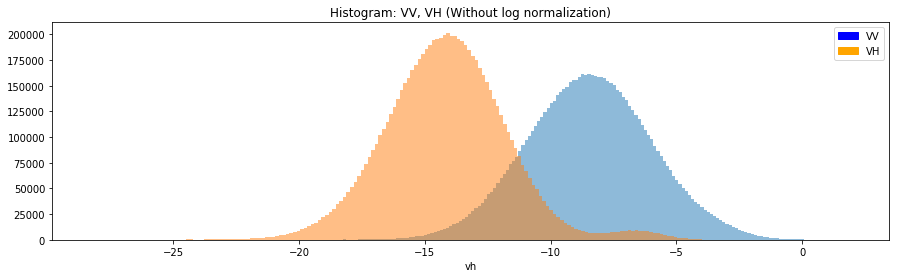

In [12]:
%matplotlib inline
import matplotlib.patches as mpatches
plt.figure(figsize = (15,4))

color_patches = list(map(lambda color, label: mpatches.Patch(color=color, label=label), ["blue", "orange"], ["VV", "VH"])) 
plt.legend(handles=color_patches, loc='best')

_ = cleaned_dataset.vv.plot.hist(bins = 200 , alpha = 0.5)
_ = cleaned_dataset.vh.plot.hist(bins = 200, alpha = 0.5)
plt.title("Histogram: VV, VH (Without log normalization)")

In [13]:
normalized_dataset = xr.merge([
    10*np.log10( - cleaned_dataset.vv),
    10*np.log10(- cleaned_dataset.vh)])

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.9-py3.5.egg/xarray/core/computation.py:561: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)
/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/xarray-0.10.9-py3.5.egg/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


In [14]:
normalized_dataset = xr.merge([
    normalized_dataset.vv.where(np.isfinite(normalized_dataset.vv)),
    normalized_dataset.vh.where(np.isfinite(normalized_dataset.vh))
])

In [15]:
import numpy as np 
def finite_histogram(data_array, *args, **kwargs):
    x = data_array.values.copy()
    x = x[~np.isnan(x)]
    x = x[np.isfinite(x)]
    
    return plt.hist(x,*args, **kwargs)

Text(0.5, 1.0, 'Histogram: VV, VH (Log Normalized)')

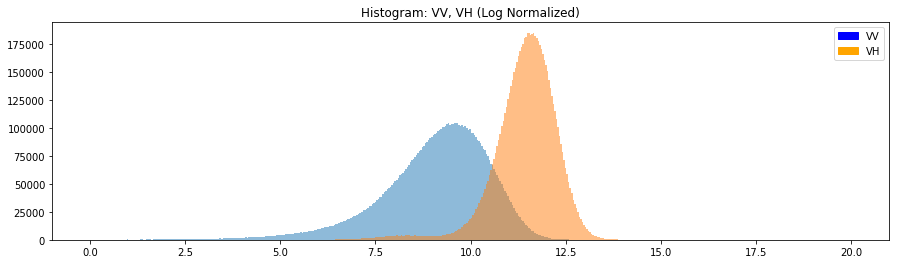

In [16]:
plt.figure(figsize = (15,4))

color_patches = list(map(lambda color, label: mpatches.Patch(color=color, label=label), ["blue", "orange"], ["VV", "VH"])) 
plt.legend(handles=color_patches, loc='best')

_ = finite_histogram(normalized_dataset.vv,bins = 500,   range=[-0, 20], alpha = 0.5)
_ = finite_histogram(normalized_dataset.vh, bins = 500,  range=[-0, 20], alpha = 0.5)
plt.title("Histogram: VV, VH (Log Normalized)")

### 2. Define Global Parameters for Deutscher algorithm

In [17]:
n = window_size = 3
band = "vv"
time_range = ("2015-09-01", "2017-01-01")

### 3. Explore Sentinel 1 statistical composites 

In [18]:
subject = normalized_dataset

In [19]:
# subject = normalized_dataset #or log_nomralized_dataset  
data_array = subject[band]
data_array = data_array.where(data_array != 0)

> #### Coefficient of Variance

In [20]:
import xarray as xr
import numpy as np  

def np_cv(arr:np.array, axis = None) -> np.array:
    mu = np.nanmean(arr, axis = axis)
    std = np.nanstd(arr, axis = axis)
    return mu/std

def global_coeffeiceint_of_variance(ds:xr.Dataset) -> xr.DataArray:
    arrays = [ds[variable].values for variable in ds.data_vars]
    concatted_array = np.concatenate(arrays)
    
    coords = list(raw_dataset.coords)[1:]
    
    return xr.DataArray(data = np_cv(concatted_array, axis = 0),
                        coords = [ds[coord] for coord in coords],
                        attrs  = ds.attrs)
    

In [21]:
# dataset_cov = global_coeffeiceint_of_variance(data_array.to_dataset(band))
dataset_cov = global_coeffeiceint_of_variance(subject) # if you wish to include both VV and VH
dataset_cov = dataset_cov.to_dataset(name = "cov")

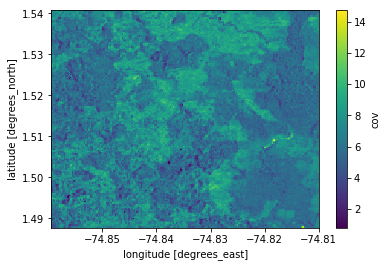

In [22]:
dataset_cov.cov.plot()

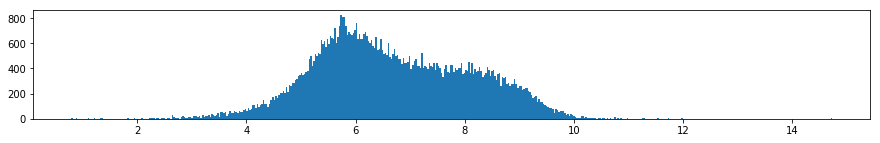

In [23]:
plt.figure(figsize = (15,2))
_ = finite_histogram(dataset_cov.cov, bins = 500)

> #### Mean

In [24]:
dataset_mean = data_array.reduce(np.nanmean, dim = "time").to_dataset(name = "mu")

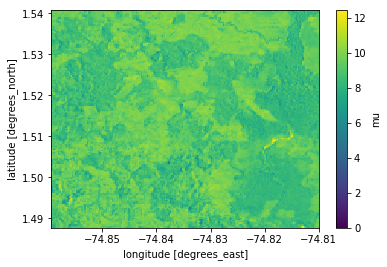

In [25]:
dataset_mean.mu.plot(vmin=0,vmax=np.max(dataset_mean.mu))

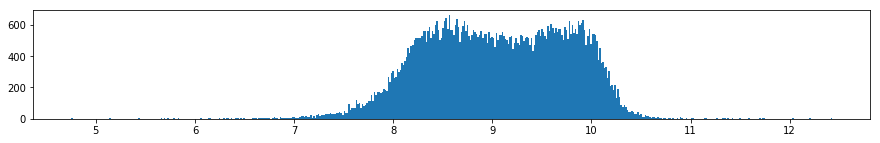

In [26]:
plt.figure(figsize = (15,2))
_ = finite_histogram(dataset_mean.mu, bins = 500)

>#### Min

In [27]:
dataset_min = data_array.min(dim = "time").to_dataset(name = "ds_min")

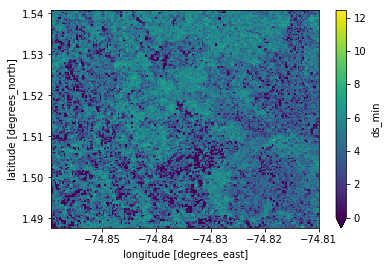

In [28]:
dataset_min.ds_min.plot(vmin=0,vmax=np.max(dataset_mean.mu))

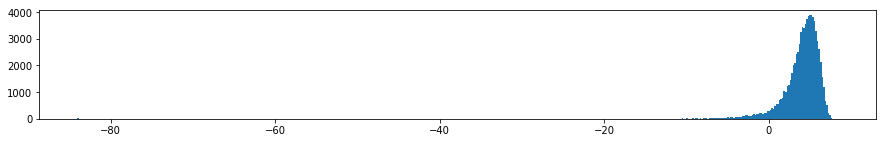

In [29]:
plt.figure(figsize = (15,2))
_ = finite_histogram(dataset_min.ds_min, bins = 500)

# All at once

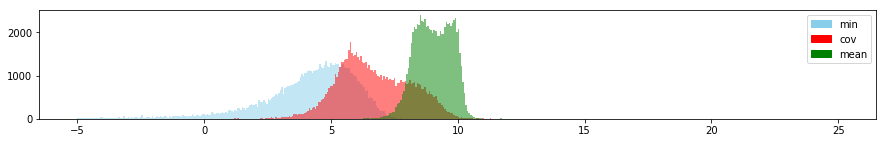

In [30]:
plt.figure(figsize = (15,2))


color_patches = list(map(lambda color, label: mpatches.Patch(color=color, label=label), ["skyblue", "red", "green"], ["min", "cov", "mean"])) 
plt.legend(handles=color_patches, loc='best')

_ = finite_histogram(dataset_min.ds_min, bins = 500, alpha = 0.5, range = [-5,25], color = "skyblue")
_ = finite_histogram(dataset_cov.cov, bins = 500, alpha = 0.5, range = [-5,25], color = "red")
_ = finite_histogram(dataset_mean.mu, bins = 500, alpha = 0.5, range = [-5,25], color = "green")

### 4. Plot RGB false color composites

In [31]:
from utils.data_cube_utilities.dc_rgb import rgb

In [32]:
import xarray as xr 
from functools import reduce  

stats_dataset = xr.merge([dataset_cov, dataset_mean, dataset_min])
stats_dataset = stats_dataset.where(reduce(np.logical_and , [np.isfinite(stats_dataset.ds_min.values),
                        np.isfinite(stats_dataset.mu.values),
                        np.isfinite(stats_dataset.cov.values)]))

> #### RGB Composite 1  
>  R : Coefficient of variation  
>  G : Mean  
>  B : Coefficient of variation  


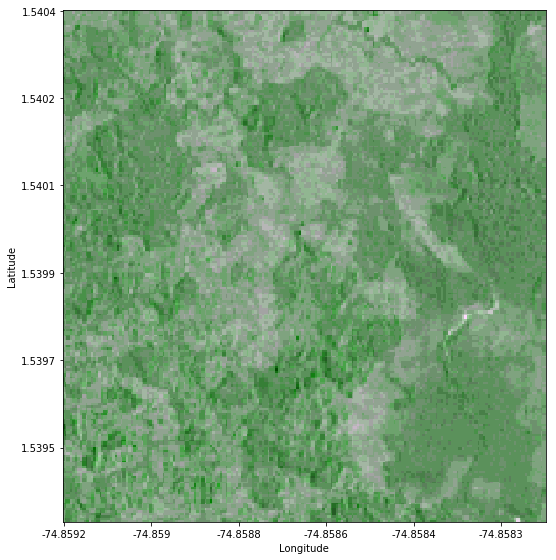

In [33]:
rgb(stats_dataset, bands= ["cov", "mu", "cov"])

> #### RGB Composite 2  
> R : Coefficient of variation  
> G : mean  
> B : minimum 


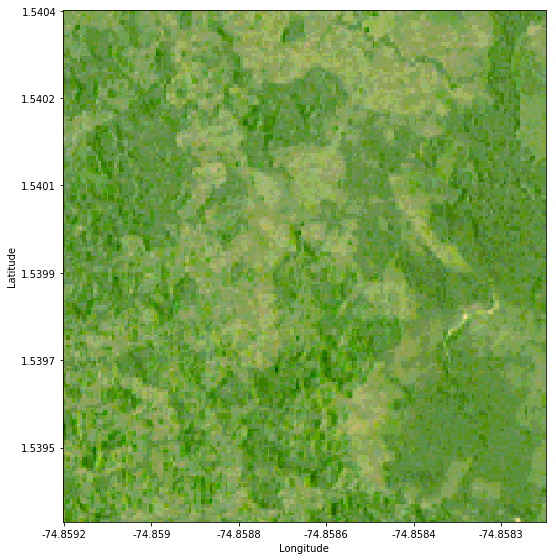

In [36]:
rgb(stats_dataset, bands= ["cov", "mu", "ds_min"])

### 5. Develop a Backscatter Trend Product

In [37]:
bt_source = data_array  

In [38]:
n_earliest_times = bt_source.time.values[0:n] ##  Select First N dates in xarray
n_latest_times   = bt_source.time.values[-n:] ##  Select Last N dates in xarray

ds_before = bt_source.sel(time = n_earliest_times) ## Subset xarray datasets into before time frame
ds_after  = bt_source.sel(time = n_latest_times)   ## Subset xarray datasets into after  time frame

In [39]:
def delta(after,before):
    return (before - after)

In [40]:
ds_after_mean  = ds_after.mean(dim = 'time')
ds_before_mean = ds_before.mean(dim = 'time')

In [41]:
bt =  delta(ds_before_mean, ds_after_mean).to_dataset(name = "backscatter_trend")

In [42]:
import numpy as np 
def finite_histogram(data_array, *args, **kwargs):
    x = data_array.values.copy()
    x = x[~np.isnan(x)]
    x = x[np.isfinite(x)]
    
    return plt.hist(x,*args, **kwargs)

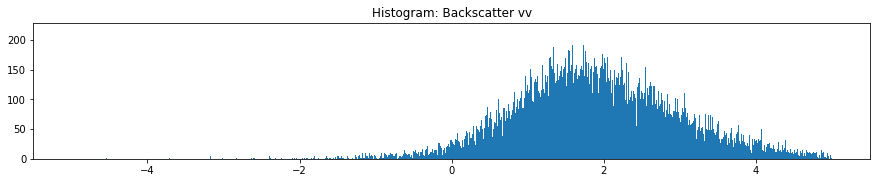

In [43]:
plt.figure(figsize = (15,2.5))
plt.title("Histogram: Backscatter {}".format(band))
_ = finite_histogram(bt.backscatter_trend, bins = 2000, range = [-5,5])

> #### Plot Backscatter Trend

In [44]:
def aspect_ratio_helper(x,y, fixed_width = 20):
    width = fixed_width
    height = y * (fixed_width / x)
    return (int(width), int(height))

In [45]:
aspect_ratio = aspect_ratio_helper(*bt.backscatter_trend.values.shape)

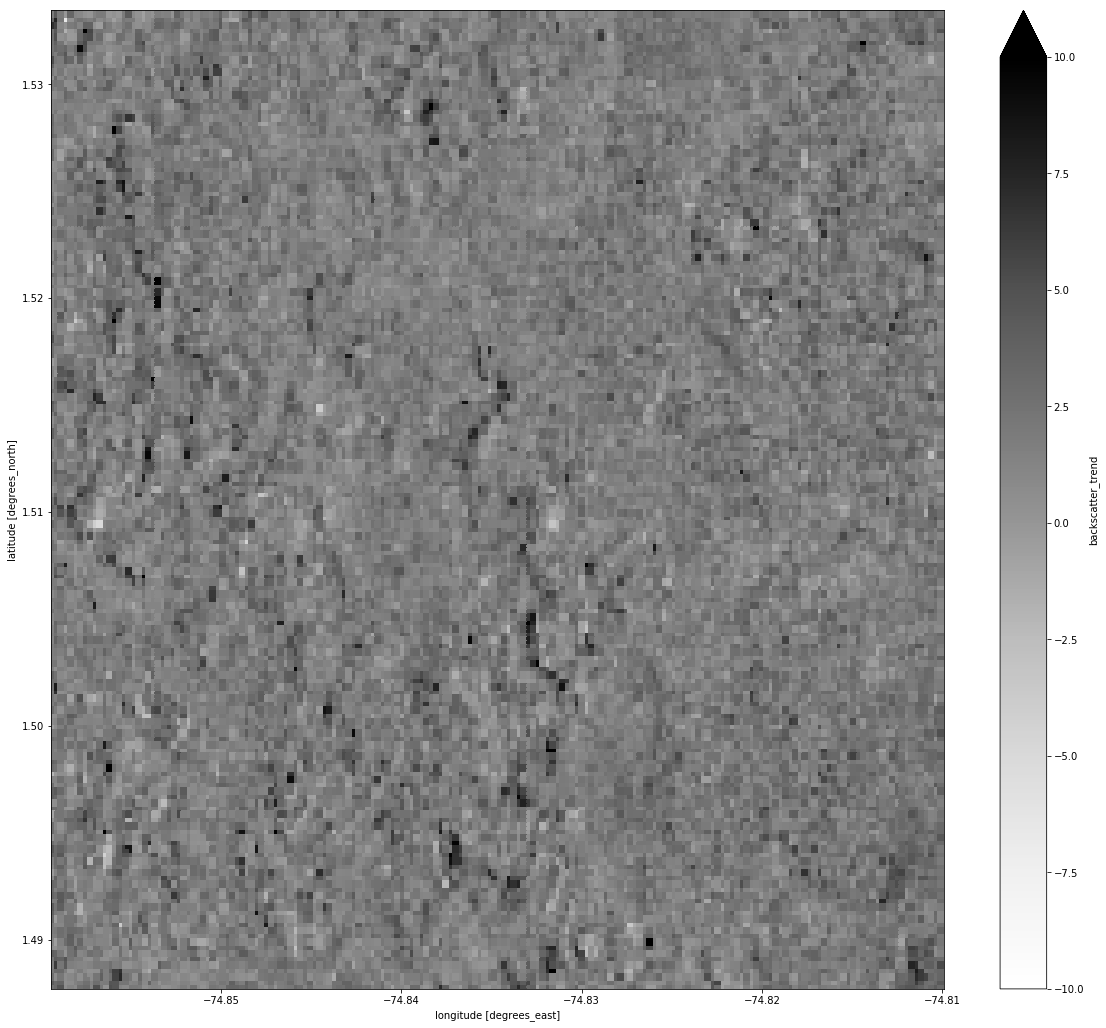

In [46]:
plt.figure(figsize = aspect_ratio)
bt.backscatter_trend\
    .isel(latitude  = slice(40,600),
          longitude = slice(0, 550))\
    .plot(cmap = "Greys", vmin = -10, vmax = 10)

### 6. Calculate a Deutscher Product

In [47]:
nbt = bt.where(np.isfinite(bt.backscatter_trend.values))

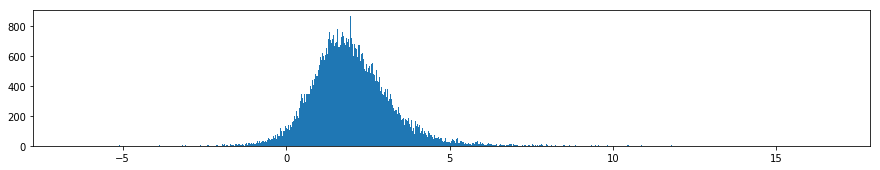

In [48]:
plt.figure(figsize = (15,2.5))
_ = finite_histogram(nbt.backscatter_trend, bins = 1000)

In [49]:
deutscher_product = stats_dataset.cov * nbt.backscatter_trend

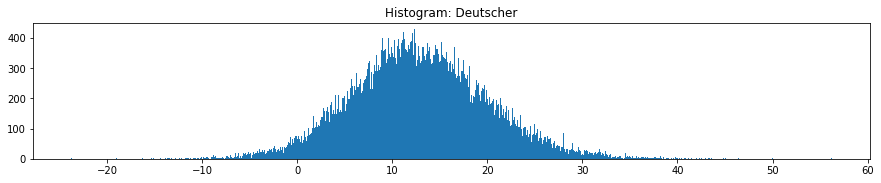

In [50]:
plt.figure(figsize = (15,2.5))
plt.title("Histogram: Deutscher")
_ = finite_histogram(deutscher_product, bins = 1000)

### 7.  Plot Deustscher

In [51]:
#Custom function for a color mapping object
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt  

def custom_color_mapper(name = "custom", val_range = (1.96,1.96), colors = "RdGnBu"):
    custom_cmap = LinearSegmentedColormap.from_list(name,colors=colors)
    
    min, max = val_range
    step = max/10.0
    Z = [min,0],[0,max]
    levels = np.arange(min,max+step,step)
    cust_map = plt.contourf(Z, 100, cmap=custom_cmap)#cmap = custom_cmap
    plt.clf()
    return cust_map.cmap

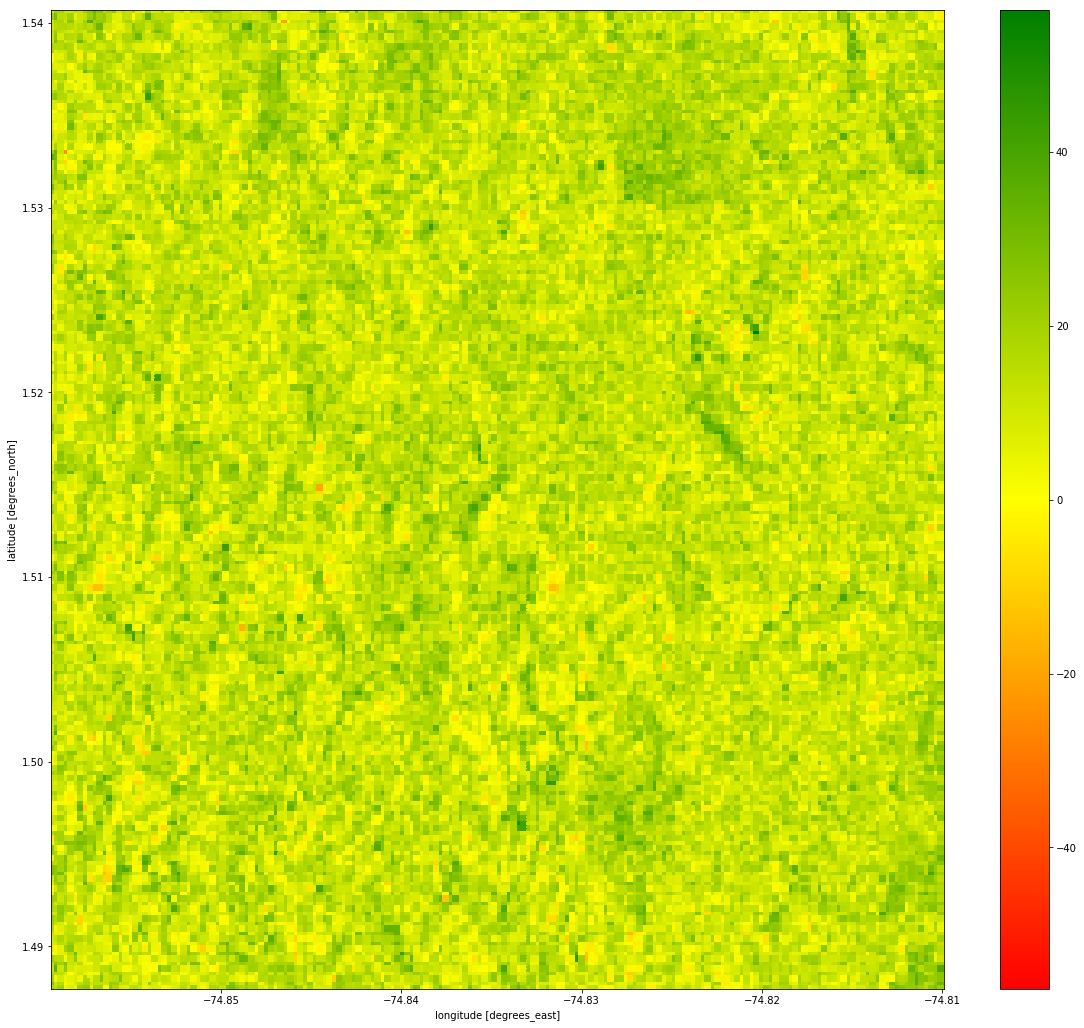

In [52]:
aspect_ratio = aspect_ratio_helper(*deutscher_product.values.shape)
plt.figure(figsize = aspect_ratio)

deutscher_colors = custom_color_mapper(name = "Deutscher", colors = ["red","yellow", "green"])

deutscher_product.plot(cmap = deutscher_colors)


In [53]:
from utils.data_cube_utilities import dc_utilities
def export_slice_to_geotiff(ds, path):
    dc_utilities.write_geotiff_from_xr(path,
                                        ds.astype(np.float32),
                                        list(ds.data_vars.keys()),
                                        crs="EPSG:4326")

In [54]:
export_slice_to_geotiff(deutscher_product.to_dataset('deutscher'), 'algorithm[{}][{}][{}].tif'.format(algorithm, version, product))

/home/localuser/Datacube/datacube_env/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: the order of the arguments on DataArray.to_dataset has changed; you now need to supply ``name`` as a keyword argument
  """Entry point for launching an IPython kernel.
